In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets # new
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [2]:
RANDOM_STATE = 24
np.random.RandomState(seed=RANDOM_STATE)
rng = np.random.default_rng(seed=RANDOM_STATE)
N_SAMPLE = 1000
NOISE = 0.2
ALPHA = 0.1 # LEARNING RATE
TEST_SIZE = 0.2
EPOCH = 20000


In [3]:
# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (12, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium',
          'savefig.dpi': 300,
          'image.cmap': plt.cm.inferno,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 2,
          'legend.numpoints' : 1
         }

plt.rcParams.update(params)
# To control the display of floating-point numbers when printing arrays. 
np.set_printoptions(precision=3,  # number of decimal places displayed
                    suppress=True) # prevents the use of scientific notation for small numbers
CMAP = plt.cm.coolwarm
# number of columns displayed when printing a DataFrame
pd.set_option("display.max_columns", 8) # maximum number of columns that will be displayed at once
pd.set_option('display.precision', 2) # precision for floating-point numbers when it’s displayed
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [4]:
# make moons
X, y = datasets.make_moons(shuffle=True, random_state=RANDOM_STATE, n_samples=N_SAMPLE, noise=NOISE) # not having noise will make the graphs look like perfect semi circlular distribution which is not a real world example
X.shape, y.shape

((1000, 2), (1000,))

,A,B,target
0,0.91,0.90,0
1,-1.12,0.76,0
2,1.89,0.42,1
3,-0.93,-0.02,0
4,-0.97,0.06,0


<Axes: xlabel='A', ylabel='B'>

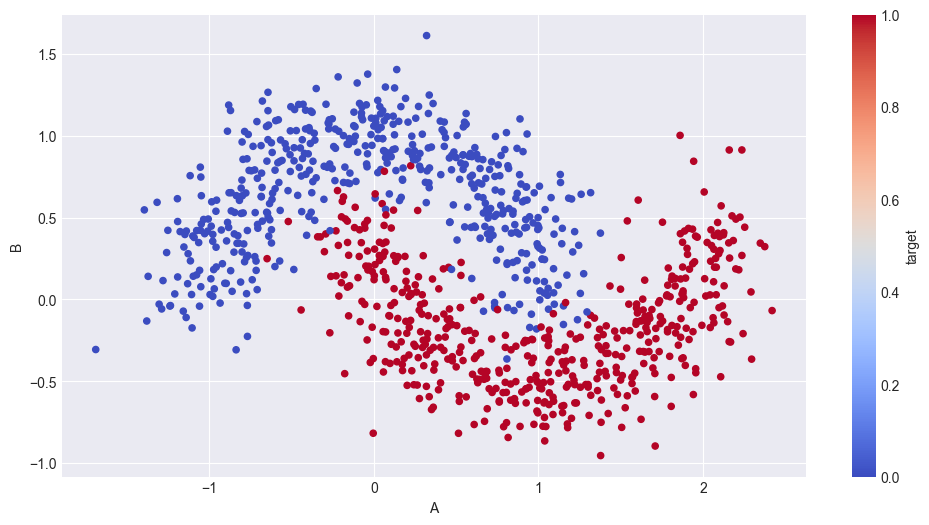

In [5]:
data_df = pd.DataFrame(X, columns=('A', 'B'))
data_df['target'] = y
display(data_df.head())
data_df.plot.scatter('A','B', c = 'target', cmap=CMAP)

In [6]:
#sigmoid activation function and tanh activation function
def sigmoid(Z):
    return 1 / (1 + (np.exp(-Z)))

def fn_acty(z):
    return np.tanh(z)
def fn_acty_prime(z): # differentiation of tanh = 1 - tanh**2
    return 1 - (np.tanh(z))**2

def fn_calculate_loss(model, X_l, y_l):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    m = X_l.shape[0]
    ## forward propagation
    # layer 1
    z1 = X_l.dot(W1) + b1 # aggregate of bias, weights and inputs
    a1 = fn_acty(z1) # activation function
    # layer 2
    z2 = a1.dot(W2) + b2 # aggregate of bias, weights and inputs
    a2 = sigmoid(z2) # activation function
    data_loss = - y_l * np.log(a2)
    return data_loss.sum() / m

In [7]:
# unit testing tanh activation
fn_acty(np.array([[-1,0,1], [-np.inf, 0, np.inf]]))

array([[-0.762,  0.   ,  0.762],
       [-1.   ,  0.   ,  1.   ]])

In [8]:
def predict(model, X_p):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    ## forward propagation
    # layer 1
    z1 = X_p.dot(W1) + b1 # aggregate of bias, weights and inputs
    a1 = fn_acty(z1) # activation function
    # layer 2
    z2 = a1.dot(W2) + b2 # aggregate of bias, weights and inputs
    a2 = sigmoid(z2) # activation function
    dec_bounds = [z1,z2]
    return a2 >= 0.5, dec_bounds

### Split data in train_test_split

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((800, 2), (200, 2), (800,), (200,))

### Building a model with a hidden layer

In [12]:
ALPHA = 0.1 # LEARNING RATE
def build_model(nn_hdim, X_t, y_t, n_epochs=EPOCH, alpha=ALPHA):
    # 2 - 4 - 1
    m, nn_input_dim = X_t.shape
    nn_output_shape = y_t.shape[1]
    # initialize weights
    W1 = rng.random((nn_input_dim, nn_hdim), dtype=np.float32) / np.sqrt(nn_input_dim)
    W2 = rng.random((nn_hdim, nn_output_shape), dtype=np.float32) / np.sqrt(nn_hdim)
    # initializing the biases
    b1 = np.zeros((1,nn_hdim), dtype=np.float32) # defining bias of hidden layer
    b2 = np.zeros((1,nn_output_shape), dtype=np.float32) # defining bias of output layer
    display(W1.shape, W2.shape)
    loss = []
    loss_hist = {}
    cur_loss = 0
    epoch = []
    for i in range(n_epochs):
        ## forward propagation
        # layer 1
        z1 = X_t.dot(W1) + b1 # aggregate of bias, weights and inputs
        a1 = fn_acty(z1) # activation function

        # layer 2
        z2 = a1.dot(W2) + b2 # aggregate of bias, weights and inputs
        a2 = sigmoid(z2) # activation function

        ## back propagation
        # layer 2
        dz2 = a2 - y_t # y should be of shape (1,m)
        dW2 = (a1.T).dot(dz2)
        assert (W2.shape == dW2.shape), 'Shape: W2: {W2.shape} and dW2: {dW2.shape}' # assert(condition), message 
        db2 = np.sum(dz2, axis=0, keepdims=True)
        assert (b2.shape == db2.shape), 'Shape: b2: {b2.shape} and db2: {db2.shape}' 
        da1 = dz2.dot(W2.T)
        assert (a1.shape == da1.shape), 'Shape: a1 {a1.shape} and da1: {da1.shape}'
        # layer 1
        dz1 = da1 * fn_acty_prime(z1)
        assert (z1.shape == dz1.shape), 'Shape: z1 {a1.shape} and dz1: {da1.shape}'
        dW1 = (X_t.T).dot(dz1)
        assert (W1.shape == dW1.shape), 'Shape: W1: {W1.shape} and dW1: {dW1.shape}'
        db1 = np.sum(dz1, axis=0, keepdims=True)
        assert (b1.shape == db1.shape), 'Shape: b1: {b1.shape} and db1: {db1.shape}' 

        ## Gradient update through gradient descent
        W1 += - alpha * dW1 / m
        W2 += - alpha * dW2 / m
        b1 += - alpha * db1 / m
        b2 += - alpha * db2 / m
        model = {'W1': W1, 'b1':b1, 'W2': W2, 'b2':b2}
        
        if i % 100 == 0:
            curr_loss = fn_calculate_loss(model, X_t, y_t)
            loss.append(curr_loss)
            epoch.append(i)
        
        if i % 1000 == 0:
            print(f"Loss after {i:>5d} epochs: {curr_loss:0.5f}")
    
    loss_hist['epoch'] = n_epochs
    loss_hist['loss'] = loss
    # printing the error reduction curve
    fig, ax = plt.subplots()
    ax.plot(loss)
    return model


#### For reshape:
#### -1: Automatically calculates the number of rows based on the total number of elements and the specified number of columns.

In [14]:
y_train = y_train.reshape(-1,1) # reshaping the y_train from a 1D array to a 2D array with shape (len(y_train),1)
y_train.shape

(800, 1)

In [15]:
# build_model(4, X_train, y_train) ## testing whether the inputs are having the correct shape before calculation

(2, 4)

(4, 1)

Loss after     0 epochs: 0.29173
Loss after  1000 epochs: 0.14811
Loss after  2000 epochs: 0.11359
Loss after  3000 epochs: 0.07976
Loss after  4000 epochs: 0.05990
Loss after  5000 epochs: 0.04288
Loss after  6000 epochs: 0.03557
Loss after  7000 epochs: 0.03220
Loss after  8000 epochs: 0.03051
Loss after  9000 epochs: 0.02960
Loss after 10000 epochs: 0.02906
Loss after 11000 epochs: 0.02872
Loss after 12000 epochs: 0.02849
Loss after 13000 epochs: 0.02833
Loss after 14000 epochs: 0.02822
Loss after 15000 epochs: 0.02813
Loss after 16000 epochs: 0.02806
Loss after 17000 epochs: 0.02801
Loss after 18000 epochs: 0.02795
Loss after 19000 epochs: 0.02791


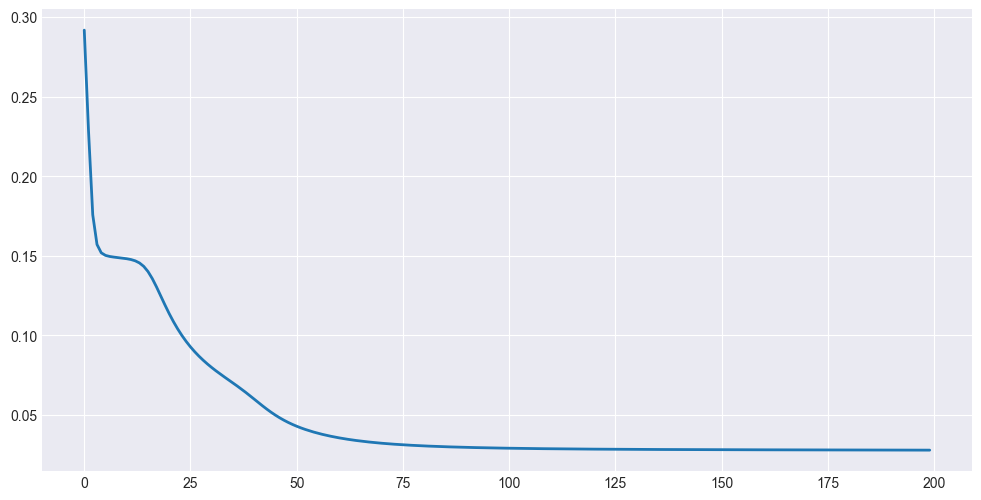

In [16]:
model = build_model(4, X_train, y_train)

(2, 4)

(4, 1)

Loss after     0 epochs: 0.29767
Loss after  1000 epochs: 0.14641
Loss after  2000 epochs: 0.10575
Loss after  3000 epochs: 0.06870
Loss after  4000 epochs: 0.04857
Loss after  5000 epochs: 0.03999
Loss after  6000 epochs: 0.03590
Loss after  7000 epochs: 0.03367
Loss after  8000 epochs: 0.03231
Loss after  9000 epochs: 0.03140
Loss after 10000 epochs: 0.03076
Loss after 11000 epochs: 0.03028
Loss after 12000 epochs: 0.02991
Loss after 13000 epochs: 0.02962
Loss after 14000 epochs: 0.02939
Loss after 15000 epochs: 0.02919
Loss after 16000 epochs: 0.02903
Loss after 17000 epochs: 0.02889
Loss after 18000 epochs: 0.02878
Loss after 19000 epochs: 0.02868


0.98125

0.965

(2, 4)

(4, 1)

Loss after     0 epochs: 0.30379
Loss after  1000 epochs: 0.21782
Loss after  2000 epochs: 0.17078
Loss after  3000 epochs: 0.15492
Loss after  4000 epochs: 0.15000
Loss after  5000 epochs: 0.14800
Loss after  6000 epochs: 0.14649
Loss after  7000 epochs: 0.14470
Loss after  8000 epochs: 0.14227
Loss after  9000 epochs: 0.13898
Loss after 10000 epochs: 0.13480
Loss after 11000 epochs: 0.12991
Loss after 12000 epochs: 0.12463
Loss after 13000 epochs: 0.11929
Loss after 14000 epochs: 0.11414
Loss after 15000 epochs: 0.10932
Loss after 16000 epochs: 0.10487
Loss after 17000 epochs: 0.10079
Loss after 18000 epochs: 0.09704
Loss after 19000 epochs: 0.09359


0.93125

0.93

(2, 4)

(4, 1)

Loss after     0 epochs: 0.29305
Loss after  1000 epochs: 0.28919
Loss after  2000 epochs: 0.28238
Loss after  3000 epochs: 0.27321
Loss after  4000 epochs: 0.26279
Loss after  5000 epochs: 0.25219
Loss after  6000 epochs: 0.24211
Loss after  7000 epochs: 0.23290
Loss after  8000 epochs: 0.22463
Loss after  9000 epochs: 0.21724
Loss after 10000 epochs: 0.21061
Loss after 11000 epochs: 0.20464
Loss after 12000 epochs: 0.19923
Loss after 13000 epochs: 0.19430
Loss after 14000 epochs: 0.18979
Loss after 15000 epochs: 0.18568
Loss after 16000 epochs: 0.18192
Loss after 17000 epochs: 0.17850
Loss after 18000 epochs: 0.17539
Loss after 19000 epochs: 0.17258


0.8675

0.84

(2, 4)

(4, 1)

Loss after     0 epochs: 0.29997
Loss after  1000 epochs: 0.02985
Loss after  2000 epochs: 0.02825
Loss after  3000 epochs: 0.02817
Loss after  4000 epochs: 0.02813
Loss after  5000 epochs: 0.02809
Loss after  6000 epochs: 0.02807
Loss after  7000 epochs: 0.02799
Loss after  8000 epochs: 0.02789
Loss after  9000 epochs: 0.02780
Loss after 10000 epochs: 0.02772
Loss after 11000 epochs: 0.02765
Loss after 12000 epochs: 0.02759
Loss after 13000 epochs: 0.02754
Loss after 14000 epochs: 0.02750
Loss after 15000 epochs: 0.02746
Loss after 16000 epochs: 0.02742
Loss after 17000 epochs: 0.02738
Loss after 18000 epochs: 0.02735
Loss after 19000 epochs: 0.02732


0.9825

0.965

(2, 4)

(4, 1)

Loss after     0 epochs: 0.42065
Loss after  1000 epochs: 0.01891
Loss after  2000 epochs: 0.01923
Loss after  3000 epochs: 0.01933
Loss after  4000 epochs: 0.02247
Loss after  5000 epochs: 0.02781
Loss after  6000 epochs: 0.03002
Loss after  7000 epochs: 0.02800
Loss after  8000 epochs: 0.02996
Loss after  9000 epochs: 0.02997
Loss after 10000 epochs: 0.01220
Loss after 11000 epochs: 0.03010
Loss after 12000 epochs: 0.02974
Loss after 13000 epochs: 0.02595
Loss after 14000 epochs: 0.03010
Loss after 15000 epochs: 0.02945
Loss after 16000 epochs: 0.02890
Loss after 17000 epochs: 0.03009
Loss after 18000 epochs: 0.02892
Loss after 19000 epochs: 0.02965


0.98125

0.96

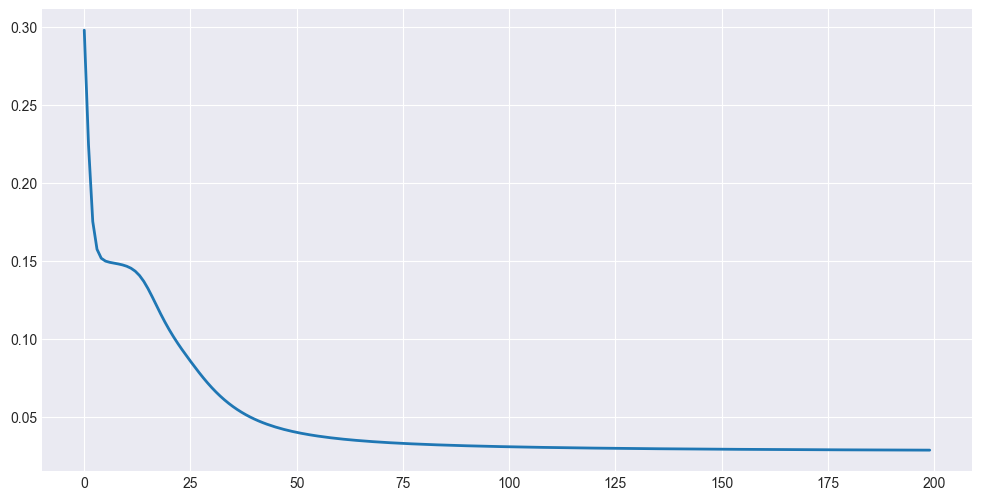

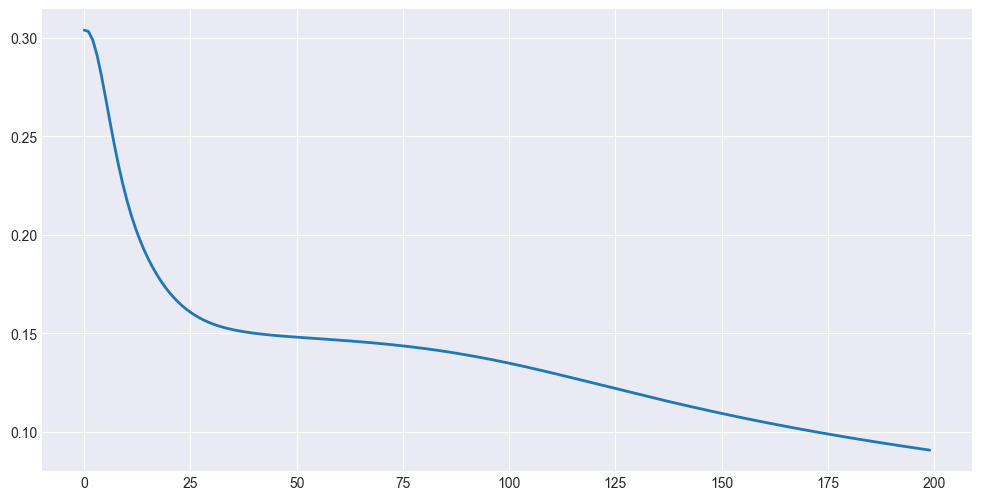

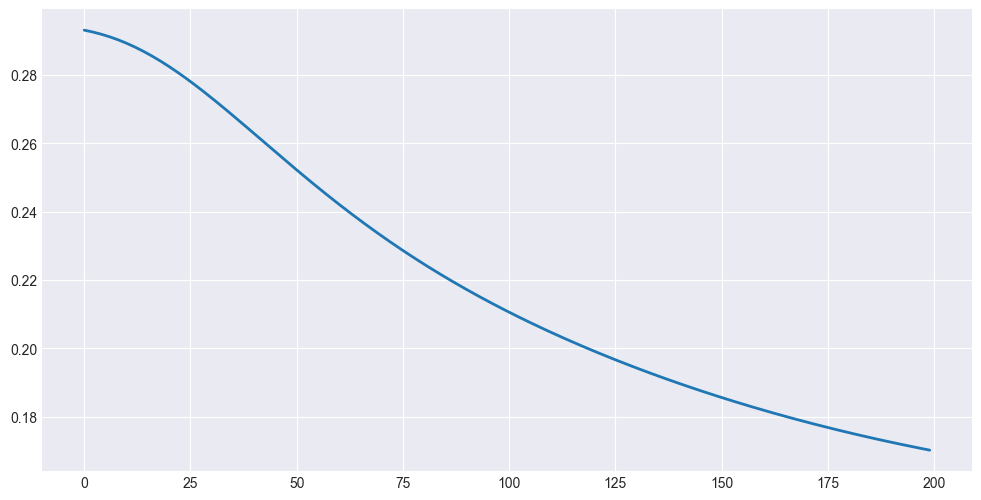

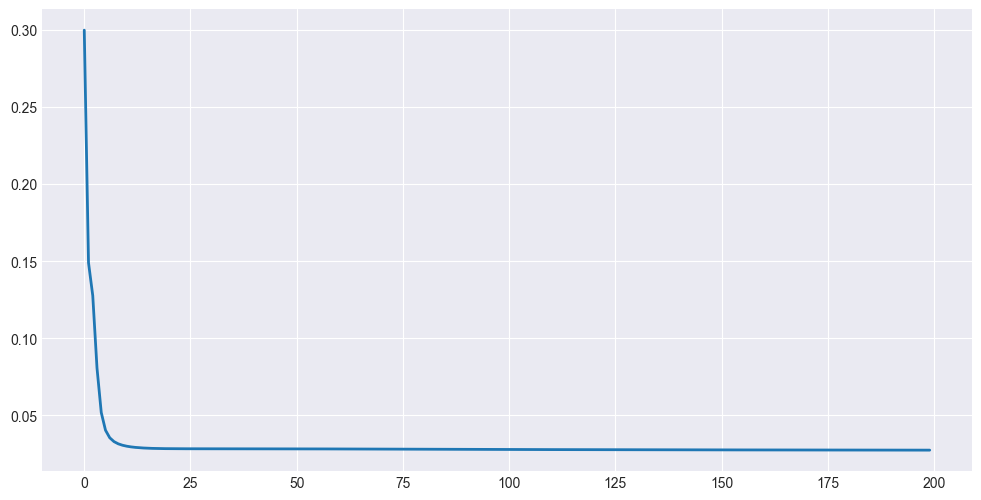

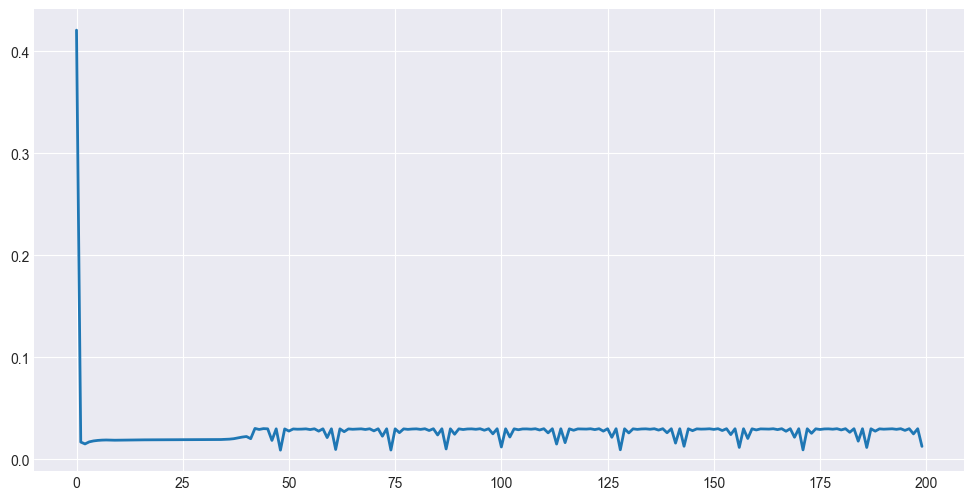

In [17]:
# assignment 3, checking the accuracy scores for multiple alpha values for only 4 neurons in the hidden layer and epochs=2000
alpha_vals = [0.1,0.01,0.001,1,10]
accuracy_vals = {}
for i in alpha_vals:
    model = build_model(4, X_train, y_train, alpha=i)
    # training accuracy score
    y_pred, dec_bounds = predict(model, X_train)
    train_accuracy = accuracy_score(y_true=y_train, y_pred=y_pred)
    display(train_accuracy)
    accuracy_vals[i] = [train_accuracy]

    # testing accuracy score
    y_pred, dec_bounds = predict(model, X_test)
    test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    display(test_accuracy)
    accuracy_vals[i].append(test_accuracy)

# for 4 neurons

In [18]:

accuracy_vals

{0.1: [0.98125, 0.965],
 0.01: [0.93125, 0.93],
 0.001: [0.8675, 0.84],
 1: [0.9825, 0.965],
 10: [0.98125, 0.96]}

# now trying to check the accuracy when number of neurons in the hidden layer are 10, epochs = 20000
alpha_vals = [0.1,0.01,0.001,1,10]
accuracy_vals = {}
for i in alpha_vals:
    model = build_model(10, X_train, y_train, alpha=i)
    # training accuracy score
    y_pred, dec_bounds = predict(model, X_train)
    train_accuracy = accuracy_score(y_true=y_train, y_pred=y_pred)
    display(train_accuracy)
    accuracy_vals[i] = [train_accuracy]

    # testing accuracy score
    y_pred, dec_bounds = predict(model, X_test)
    test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    display(test_accuracy)
    accuracy_vals[i].append(test_accuracy)

# for 10 neurons

In [20]:

accuracy_vals

{0.1: [0.98, 0.965],
 0.01: [0.94, 0.95],
 0.001: [0.87, 0.845],
 1: [0.9825, 0.965],
 10: [0.98, 0.955]}

(2, 50)

(50, 1)

Loss after     0 epochs: 0.23629
Loss after  1000 epochs: 0.14073
Loss after  2000 epochs: 0.08945
Loss after  3000 epochs: 0.05232
Loss after  4000 epochs: 0.04200
Loss after  5000 epochs: 0.03756
Loss after  6000 epochs: 0.03508
Loss after  7000 epochs: 0.03350
Loss after  8000 epochs: 0.03240
Loss after  9000 epochs: 0.03158
Loss after 10000 epochs: 0.03094
Loss after 11000 epochs: 0.03041
Loss after 12000 epochs: 0.02997
Loss after 13000 epochs: 0.02959
Loss after 14000 epochs: 0.02926
Loss after 15000 epochs: 0.02896
Loss after 16000 epochs: 0.02870
Loss after 17000 epochs: 0.02847
Loss after 18000 epochs: 0.02825
Loss after 19000 epochs: 0.02806


0.97875

0.97

(2, 50)

(50, 1)

Loss after     0 epochs: 0.19850
Loss after  1000 epochs: 0.17232
Loss after  2000 epochs: 0.15309
Loss after  3000 epochs: 0.14792
Loss after  4000 epochs: 0.14546
Loss after  5000 epochs: 0.14340
Loss after  6000 epochs: 0.14109
Loss after  7000 epochs: 0.13817
Loss after  8000 epochs: 0.13437
Loss after  9000 epochs: 0.12948
Loss after 10000 epochs: 0.12347
Loss after 11000 epochs: 0.11653
Loss after 12000 epochs: 0.10906
Loss after 13000 epochs: 0.10153
Loss after 14000 epochs: 0.09434
Loss after 15000 epochs: 0.08776
Loss after 16000 epochs: 0.08189
Loss after 17000 epochs: 0.07675
Loss after 18000 epochs: 0.07228
Loss after 19000 epochs: 0.06841


0.94375

0.95

(2, 50)

(50, 1)

Loss after     0 epochs: 0.20173
Loss after  1000 epochs: 0.24699
Loss after  2000 epochs: 0.24405
Loss after  3000 epochs: 0.22945
Loss after  4000 epochs: 0.21544
Loss after  5000 epochs: 0.20392
Loss after  6000 epochs: 0.19467
Loss after  7000 epochs: 0.18724
Loss after  8000 epochs: 0.18118
Loss after  9000 epochs: 0.17618
Loss after 10000 epochs: 0.17202
Loss after 11000 epochs: 0.16852
Loss after 12000 epochs: 0.16555
Loss after 13000 epochs: 0.16303
Loss after 14000 epochs: 0.16088
Loss after 15000 epochs: 0.15903
Loss after 16000 epochs: 0.15743
Loss after 17000 epochs: 0.15606
Loss after 18000 epochs: 0.15487
Loss after 19000 epochs: 0.15383


0.875

0.85

(2, 50)

(50, 1)

Loss after     0 epochs: 0.37119
Loss after  1000 epochs: 0.03117
Loss after  2000 epochs: 0.02773
Loss after  3000 epochs: 0.02682
Loss after  4000 epochs: 0.02647
Loss after  5000 epochs: 0.02631
Loss after  6000 epochs: 0.02622
Loss after  7000 epochs: 0.02616
Loss after  8000 epochs: 0.02611
Loss after  9000 epochs: 0.02606
Loss after 10000 epochs: 0.02598
Loss after 11000 epochs: 0.02589
Loss after 12000 epochs: 0.02583
Loss after 13000 epochs: 0.02584
Loss after 14000 epochs: 0.02585
Loss after 15000 epochs: 0.02584
Loss after 16000 epochs: 0.02582
Loss after 17000 epochs: 0.02579
Loss after 18000 epochs: 0.02577
Loss after 19000 epochs: 0.02575


0.98125

0.96

(2, 50)

(50, 1)

Loss after     0 epochs: 3.74860
Loss after  1000 epochs: 0.02443
Loss after  2000 epochs: 0.03015
Loss after  3000 epochs: 0.01259
Loss after  4000 epochs: 0.00872
Loss after  5000 epochs: 0.01026
Loss after  6000 epochs: 0.04807
Loss after  7000 epochs: 0.00811
Loss after  8000 epochs: 0.01560
Loss after  9000 epochs: 0.01667
Loss after 10000 epochs: 0.01219
Loss after 11000 epochs: 0.01023
Loss after 12000 epochs: 0.00897
Loss after 13000 epochs: 0.00799
Loss after 14000 epochs: 0.00717
Loss after 15000 epochs: 0.00643
Loss after 16000 epochs: 0.00573
Loss after 17000 epochs: 0.00485
Loss after 18000 epochs: 0.00428
Loss after 19000 epochs: 0.00384


1.0

0.95

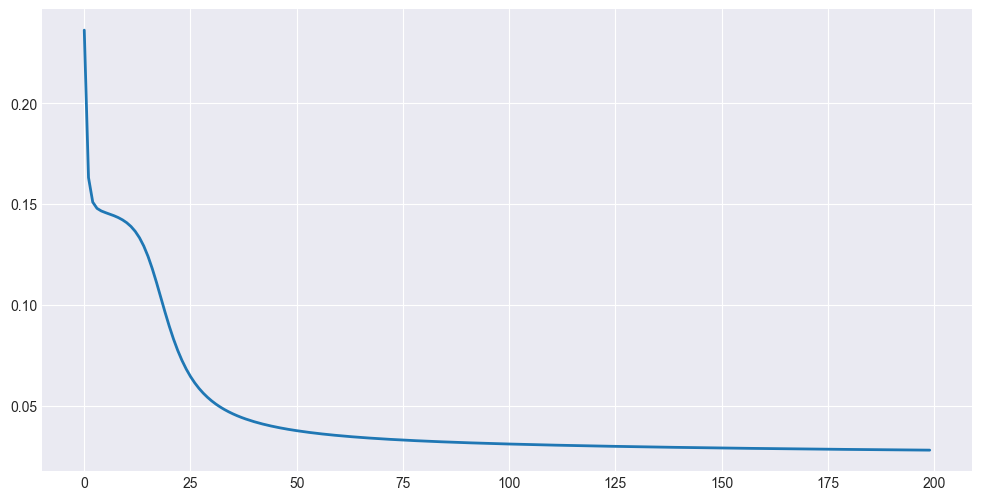

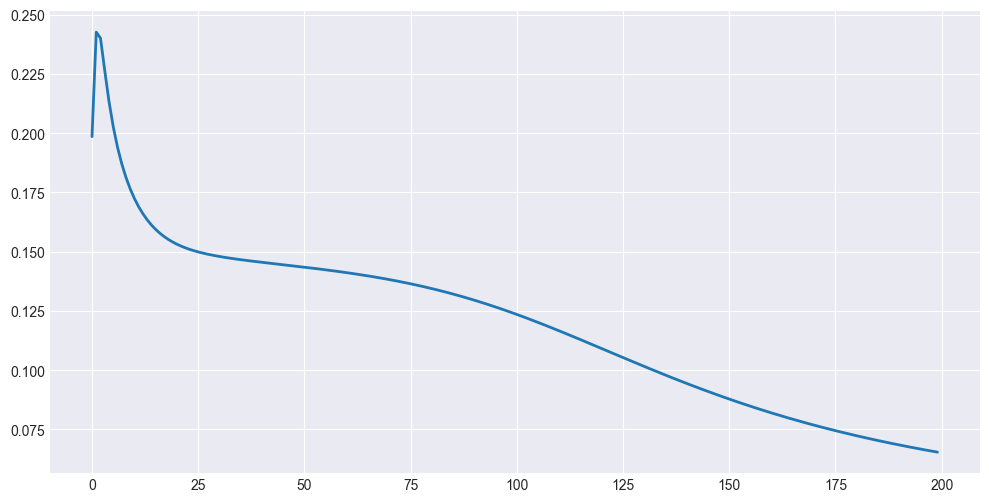

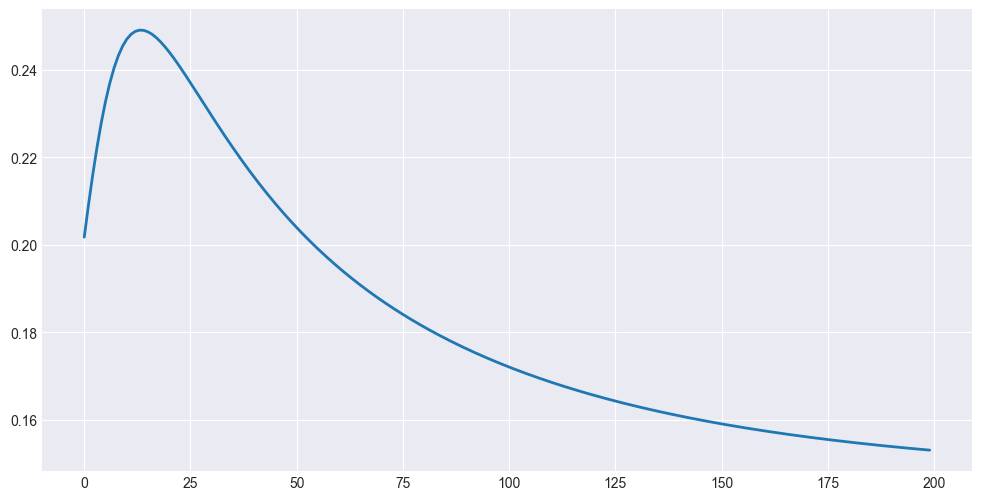

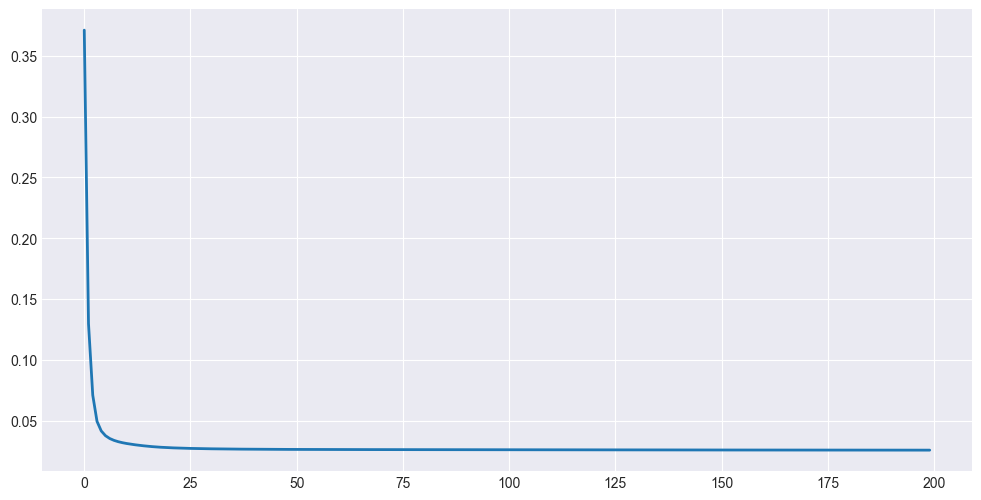

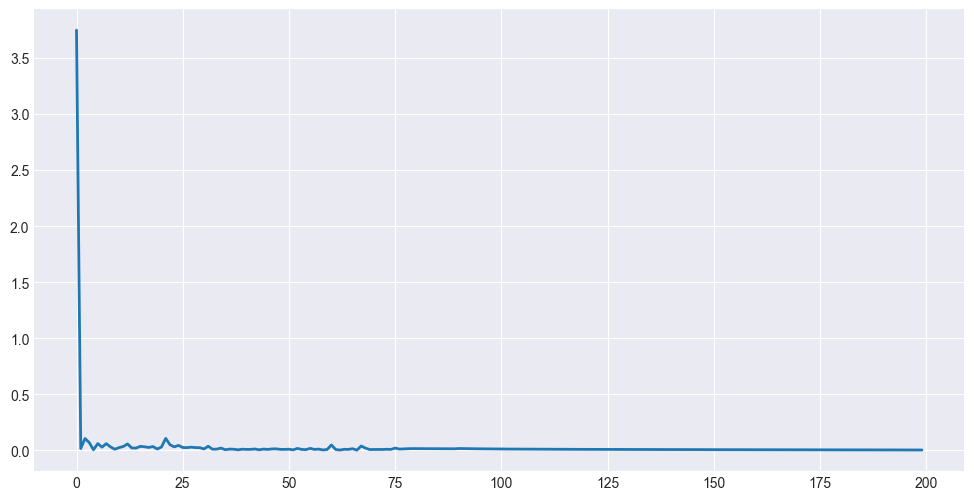

In [21]:
# now trying to check the accuracy when number of neurons in the hidden layer are 50, epochs = 20000
alpha_vals = [0.1,0.01,0.001,1,10]
accuracy_vals = {}
for i in alpha_vals:
    model = build_model(50, X_train, y_train, alpha=i)
    # training accuracy score
    y_pred, dec_bounds = predict(model, X_train)
    train_accuracy = accuracy_score(y_true=y_train, y_pred=y_pred)
    display(train_accuracy)
    accuracy_vals[i] = [train_accuracy]

    # testing accuracy score
    y_pred, dec_bounds = predict(model, X_test)
    test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    display(test_accuracy)
    accuracy_vals[i].append(test_accuracy)

# for 50 neurons

In [22]:

accuracy_vals

{0.1: [0.97875, 0.97],
 0.01: [0.94375, 0.95],
 0.001: [0.875, 0.85],
 1: [0.98125, 0.96],
 10: [1.0, 0.95]}

# Ques-2
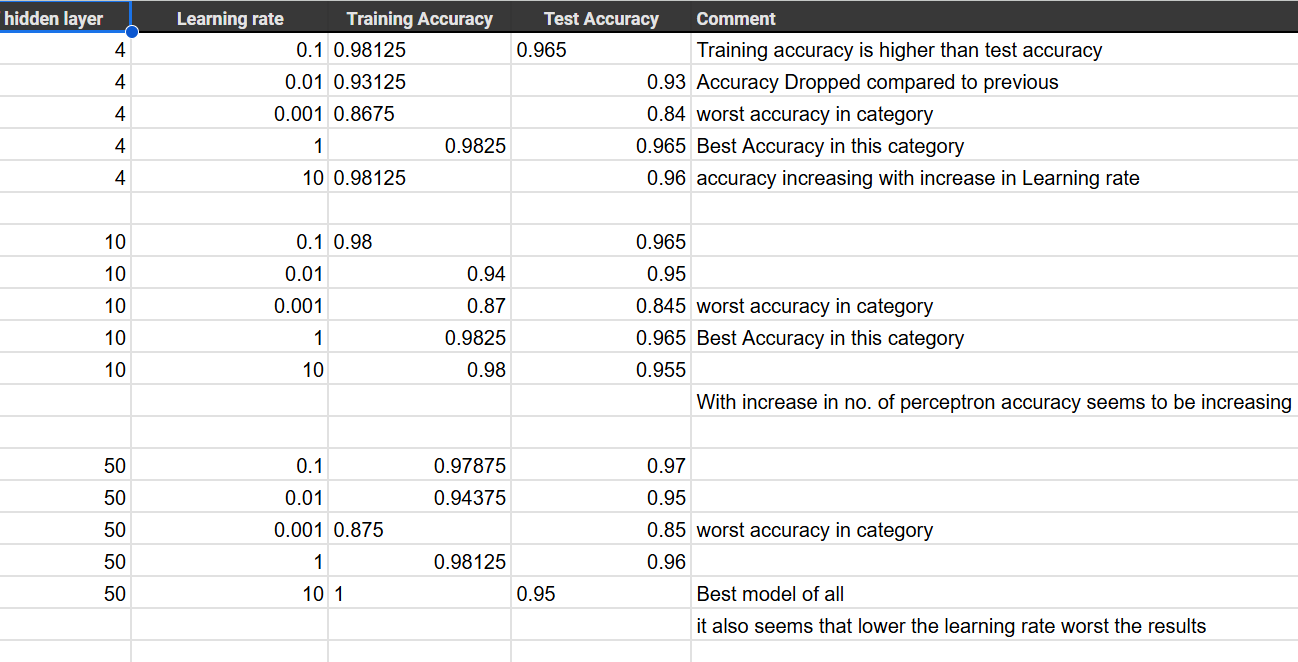

# Ques1 : Yes, current model is more accurate than previous one

# Ques 3

# Output Layer:
* one neuron for each class .
For example, if you have 3 classes,
* the output layer will have 3 neurons.
 * Use a softmax activation function for the output layer.
* Softmax transforms the raw scores (logits) into probability distributions over the classes,
* ensuring that the sum of the probabilities across all classes is 1.

# Loss Function:
* For binary classification,  use binary cross-entropy.
* For Multi-Class Classification:
   * use categorical cross-entropy.



# Ques 4

* 20000 - 30000 epochs are sufficient